<p style=font-size:200%;font-weight:bold>加密货币因子计算 </p>

- warnings的作用
- f'{WD}1202_crypto_eret_cmkt.pq'哪来的

In [27]:
import os
import warnings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from pandarallel import pandarallel
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = 'all'
pd.set_option('display.max_columns', 500)
pandarallel.initialize(progress_bar=True, nb_workers=24)

ROOT = "/home/team_crypto/2022_crypto_return/"
WD = f"{ROOT}03_wdata/0001_teaching/"
RD = f"{ROOT}02_rdata/"

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# 日频数据

## 读入数据

In [2]:
df = pd.read_parquet(f'{WD}1102_crypto_day.pq')
df.shape
df = df.loc[df['market_caps'] >= 10 ** 6]
df.shape
df.sample(3)

(5183084, 8)

(1600069, 8)

,prices,market_caps,total_volumes,id,symbol,name,time,daily_ret
412,0.026373,3.677886e+06,3.158508e+06,bitmart-token,bmx,BitMart Token,2019-09-24,-0.026641
2121,0.229764,5.904943e+06,6.907397e+04,peercoin,ppc,Peercoin,2019-10-24,-0.082055
826,0.268482,1.879671e+07,9.309719e+04,iexec-rlc,rlc,iExec RLC,2019-07-25,0.026495


In [3]:
df.sort_values(['id', 'time'], ascending=True, inplace=True)

<AxesSubplot:>

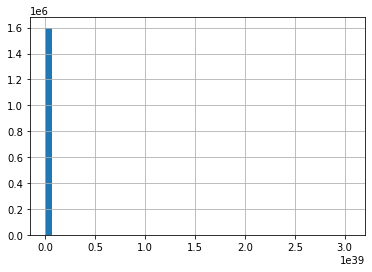

In [4]:
df['daily_ret'].hist(bins=50)

<AxesSubplot:>

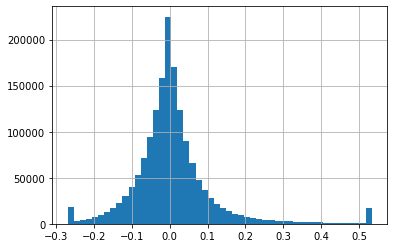

In [5]:
df.loc[df['daily_ret'] <= df['daily_ret'].quantile(0.01), 'daily_ret'] = df['daily_ret'].quantile(0.01)
df.loc[df['daily_ret'] >= df['daily_ret'].quantile(0.99), 'daily_ret'] = df['daily_ret'].quantile(0.99)
df['daily_ret'].hist(bins=50)

## 无风险利率

In [6]:
rf = pd.read_csv(f'{RD}F-F_Research_Data_Factors_daily.csv', skiprows=[0,1,2,3], names=['time', 'mkt-rf', 'smb', 'hml', 'rf'] )
#F-F的数据库前三行为文字第四行为空,用skiprows去掉前四行
rf.shape
rf.dropna(how='any', inplace=True)
#how用来决定是否只要出现了一个nan就去掉一行
rf.shape
rf['time'] = pd.to_datetime(rf['time'])
rf = rf.loc[:, ['time', 'rf']]
#rf.dtypes
#rf为基类object
rf['rf'] = rf['rf'].map(float) / 100
rf.sample(3)

(25170, 5)

(25168, 5)

,time,rf
16317,1986-12-17,0.00022
837,1929-04-24,0.00014
11270,1966-11-11,0.00020


In [7]:
#df['time']
#df['time'].nunique()
#df['time'].value_counts()
dates = df['time'].drop_duplicates().to_frame()
#to_frame的作用是可以形成单独的dataframe
dates.shape
dates.sample(3)
#F-F的rf日频率有很多重复

(2990, 1)

,time
389,2019-08-12
568,2015-07-24
19,2017-11-05


In [8]:
rfm = dates.merge(rf, on=['time'], how='outer').set_index('time').sort_index()
#how='outer'取并集
#on取最大然后按照on分两列放merge的双方，空缺的放nan
rfm.isna().sum()
rfm.head(3)
rfm.tail(3)

rf    955
dtype: int64

,rf
time,
1926-07-01,0.00009
1926-07-02,0.00009
1926-07-06,0.00009


,rf
time,
2022-03-07,NaN
2022-03-08,NaN
2022-03-09,NaN


In [9]:
rfm['rf'] = rfm['rf'].interpolate()
#为了解决加密货币交易日和股票市场交易日FF差异做interpolate
rfm['rf'].isna().sum()

0

In [10]:
dfm = df.merge(rfm.reset_index(), on=['time'], how='left', indicator=True, validate='m:1') 
dfm['_merge'].value_counts()
dfm.sample(3)

both          1600069
left_only           0
right_only          0
Name: _merge, dtype: int64

,prices,market_caps,total_volumes,id,symbol,name,time,daily_ret,rf,_merge
1292904,0.360020,6.749310e+06,2.040731e+04,starship,starship,StarShip,2022-03-01,0.099815,0.0,both
447696,6.809854,8.239833e+07,9.034924e+05,dvf,dvf,DeversiFi,2022-01-01,-0.026555,0.0,both
471860,1.496254,2.805604e+07,1.215356e+06,elastos,ela,Elastos,2020-12-03,-0.024194,0.0,both


In [11]:
#dfm.drop(columns=['_merge']).to_parquet(f'{WD}1200_crypto_day_rf.pq')

## 市场日回报率

In [12]:
df = pd.read_parquet(f'{WD}1103_crypto_week.pq')
df.shape
df.sample(3)

(240380, 17)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day
227508,wax,2019,50,2019-12-13,0.019342,0.021885,1.838820e+07,172563.715175,143152.795702,34381.787205,8.592865e+06,-0.022986,0.033759,0.026858,waxp,WAX,5
208400,tokenclub,2018,23,2018-06-08,0.061766,0.065253,2.973584e+07,470859.793449,461518.818408,170823.293718,7.645795e+06,0.001453,0.066480,0.042459,tct,TokenClub,5
223518,vexanium,2020,42,2020-10-16,0.003140,0.003147,2.206016e+06,70226.596826,46944.227834,30287.465248,2.334040e+07,0.017892,0.119657,0.045195,vex,Vexanium,5


In [13]:
df.sort_values(['id', 'year', 'week'], ascending=True, inplace=True)
df.duplicated(subset=['id', 'year', 'week']).sum()

0

# 计算因子

## 规模

In [14]:
df['size_mcap'] = df.groupby(['id'])['market_caps'].shift()
df['size_prc'] = df.groupby(['id'])['prices'].shift()
df['size_maxprc'] = df.groupby(['id'])['max_prices'].shift()
df['size_age'] = df.groupby(['id'])['time'].rank().shift() * 7
#rank函数排序年份越大rank越大
df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxprc,size_age
25588,bitcoinstaking,2021,49,2021-12-10,1.195031,1.916189,1.535490e+07,4.277740e+02,2.091304e+02,3.332899e+02,2.850957e+02,-0.071432,0.553651,0.374390,bsk,BitcoinStaking,5,4.654406e+07,3.635129,4.510931,28.0
182153,sentinel-protocol,2021,17,2021-04-30,0.162419,0.172451,5.269683e+07,4.155964e+07,1.062568e+07,5.253844e+07,2.684197e+08,0.025748,0.277478,0.120256,upp,Sentinel Protocol,5,4.653175e+07,0.141161,0.213391,1043.0
117600,litecoin,2020,39,2020-09-25,44.910404,48.536471,2.942985e+09,1.752303e+09,1.823896e+09,1.386695e+08,3.844845e+07,-0.011047,0.045122,0.042337,ltc,Litecoin,5,3.203491e+09,48.811978,50.828865,2457.0


## 动量

In [15]:
for i, j in [(1, 0), (2, 0), (3, 0), (4, 0), (4, 1), (8, 0), (16, 0), (50, 0), (100, 0)]:
    df['prc_i'] = df.groupby(['id'])['prices'].shift(i + 1)
    df['prc_j'] = df.groupby(['id'])['prices'].shift(j + 1)
    df[f'mom_{i}_{j}'] = df['prc_j'] / df['prc_i'] - 1

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0
164753,project-shivom,2018,50,2018-12-14,0.001529,0.002013,1.062745e+06,4117.396692,820.384862,4485.531246,2.432844e+06,-0.041239,0.041241,0.066215,omx,Project SHIVOM,5,1.450182e+06,0.002083,0.002723,182.0,NaN,0.002083,-0.263697,-0.279163,-0.534959,-0.649116,-0.523452,-0.614687,-0.700637,NaN,NaN
114232,lcx,2020,27,2020-07-03,0.009898,0.009898,5.390999e+06,336330.174844,404666.718004,45161.764233,3.665168e+07,0.010818,0.141911,0.087770,lcx,LCX,5,5.088431e+06,0.009393,0.010604,35.0,NaN,0.009393,-0.187305,-0.068156,-0.131736,-0.342949,-0.191516,NaN,NaN,NaN,NaN
214293,ulord,2020,40,2020-10-02,0.018886,0.020439,2.770186e+06,326493.459324,305224.248906,16652.267628,1.652342e+07,-0.008220,0.043873,0.026545,ut,Ulord,5,2.996793e+06,0.020052,0.020443,714.0,0.149009,0.020052,-0.081951,0.094454,-0.051867,-0.052577,0.031996,0.363217,0.324548,0.218258,-0.865432


## 交易量

In [16]:
df['volume_vol'] = df.groupby(['id'])['unit_volumes'].shift()
df['volume_vol'] = np.log(df['volume_vol'] + 1)

df['volume_prcvol'] = df.groupby(['id'])['avg_volumes'].shift()
df['volume_prcvol'] = np.log(df['avg_volumes'] + 1)

df['volume_volscaled'] = df.groupby(['id'])['avg_volumes'].shift() / df.groupby(['id'])['market_caps'].shift()
df['volume_volscaled'] = np.log(df['volume_volscaled'] + 1)

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled
234778,yieldwatch,2021,47,2021-11-26,0.244602,0.244602,2.404049e+06,2.386254e+04,1.617595e+04,1.002550e+04,1.020824e+05,0.020677,0.116917,0.065042,watch,Yieldwatch,5,2.098779e+06,0.214540,0.223663,266.0,NaN,0.214540,-0.053512,-0.023362,0.011913,-0.055338,-0.001929,-0.325737,-0.448051,NaN,NaN,12.851520,10.080107,0.037904
198784,super-zero,2020,30,2020-07-24,0.187152,0.208319,5.187062e+07,1.057615e+07,6.859386e+06,3.119624e+06,5.334687e+07,-0.013010,0.007362,0.022903,sero,SERO,5,5.695443e+07,0.205454,0.248760,336.0,NaN,0.205454,0.035878,0.661927,0.816103,1.006368,0.936877,1.594245,2.063834,NaN,NaN,18.011703,16.174112,0.231807
152508,pancaketools,2021,33,2021-08-17,0.006843,0.006920,1.002321e+06,6.951286e+03,9.141838e+03,3.097908e+03,1.011947e+06,0.006442,0.008399,0.002768,tcake,PancakeTools,2,1.042871e+06,0.007155,0.007499,133.0,NaN,0.007155,-0.067942,-0.107720,0.008742,-0.235698,-0.179984,-0.575245,-0.844382,NaN,NaN,14.671777,8.846826,0.016198


## 波动性

In [17]:
df['vol_retvol'] = df.groupby(['id'])['std_daily_ret'].shift()
df['vol_maxret'] = df.groupby(['id'])['max_daily_ret'].shift()
df['vol_stdprcvol'] = df.groupby(['id'])['std_volumes'].shift()
df['vol_damihud'] = df.groupby(['id'])['avg_daily_ret'].shift().map(abs) / df.groupby(['id'])['avg_volumes'].shift()

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud
142883,noia-network,2020,53,2021-01-01,0.195595,0.231629,6.823041e+07,1.650049e+06,1.480540e+06,554390.046030,7.602241e+06,-0.023096,0.027103,0.041014,noia,Syntropy,5,8.068754e+07,0.231605,0.243249,336.0,NaN,0.231605,-0.055229,0.326569,0.822718,1.261386,1.393582,2.755892,1.286991,NaN,NaN,16.239825,14.316316,0.030370,0.123953,0.157303,7.231936e+05,5.692778e-10
160640,polkabridge,2021,17,2021-04-30,0.314879,0.347546,6.326019e+06,1.360198e+06,1.436002e+06,105741.396806,4.462391e+06,0.007105,0.130315,0.094670,pbr,PolkaBridge,5,6.229679e+06,0.307923,0.386847,84.0,NaN,0.307923,-0.215456,-0.264296,0.140031,0.287620,0.641234,-0.323127,NaN,NaN,NaN,15.355955,14.123142,0.227545,0.062910,0.029655,2.389955e+05,2.027697e-08
38584,cellframe,2021,42,2021-10-22,0.849468,0.954532,2.062444e+07,1.329414e+06,1.558765e+06,376001.043230,1.530800e+06,-0.005787,0.181002,0.096325,cell,Cellframe,5,2.198918e+07,0.908627,1.485880,49.0,NaN,0.908627,-0.421171,-0.087223,-0.385416,-0.443563,-0.038684,NaN,NaN,NaN,NaN,14.375977,14.100249,0.086655,0.089581,0.051257,1.575751e+06,3.579900e-08


In [18]:
er = pd.read_parquet(f'{WD}1202_crypto_eret_cmkt.pq')
er.shape
er.sample(3)

(1600069, 6)

,id,time,eret,cmkt,cmkt_l1,cmkt_l2
304993,comsa,2019-04-08,-0.014170,0.027590,0.003034,0.037366
609051,governor-dao,2021-09-02,-0.018599,0.047923,0.024541,-0.024311
629874,harvest-finance,2020-12-16,0.040398,0.005007,0.002231,0.022019


In [19]:
df['time_l1'] = df.groupby(['id'])['time'].shift()
df['key'] = df[['id', 'time_l1']].values.tolist()
#to_frame()的反向操作，把dataframe(pd series)/array[序列]变成list(np list)
#这里将dataframe的某一列变为含有list的列

df.sample(3)

,id,year,week,time,prices,max_prices,market_caps,avg_volumes,eow_volumes,std_volumes,unit_volumes,avg_daily_ret,max_daily_ret,std_daily_ret,symbol,name,day,size_mcap,size_prc,size_maxprc,size_age,prc_i,prc_j,mom_1_0,mom_2_0,mom_3_0,mom_4_0,mom_4_1,mom_8_0,mom_16_0,mom_50_0,mom_100_0,volume_vol,volume_prcvol,volume_volscaled,vol_retvol,vol_maxret,vol_stdprcvol,vol_damihud,time_l1,key
115067,lepricon,2021,48,2021-12-03,0.010230,0.011324,2.636624e+06,6.479010e+04,39607.172680,4.531600e+04,5.924628e+06,-0.017778,0.012812,0.031912,l3p,Lepricon,5,3.012310e+06,0.011636,0.012599,196.0,NaN,0.011636,0.028955,0.061858,0.571474,0.884212,0.831190,0.976505,0.206014,NaN,NaN,15.609714,11.078923,0.022053,0.077841,0.114119,30663.776570,9.993806e-08,2021-11-26,"[lepricon, 2021-11-26 00:00:00]"
73653,enigma,2021,37,2021-09-17,0.109611,0.114794,9.071491e+06,2.316682e+05,254434.504332,2.702468e+04,2.242163e+06,0.003966,0.120835,0.066491,eng,Enigma,5,8.984978e+06,0.107991,0.124464,1407.0,0.311581,0.107991,-0.107406,0.172836,0.222299,0.291581,0.446997,0.357090,-0.014193,-0.793912,-0.653411,14.617493,12.353066,0.027367,0.083798,0.143087,48037.264914,5.269996e-08,2021-09-10,"[enigma, 2021-09-10 00:00:00]"
161627,polylastic,2021,46,2021-11-19,0.001487,0.002408,1.366644e+07,1.822396e+06,772317.524975,2.175836e+06,8.965850e+08,0.006421,0.570763,0.254647,polx,Polylastic,5,1.538108e+07,0.001659,0.001728,189.0,NaN,0.001659,0.028258,0.906687,0.073991,1.251206,1.189340,1.016398,3.878172,NaN,NaN,20.535828,14.415663,0.083682,0.090396,0.153149,620765.793642,5.478521e-09,2021-11-12,"[polylastic, 2021-11-12 00:00:00]"


In [20]:
#df[['id', 'time_l1']]
#df[['id', 'time_l1']].values
#df[['id', 'time_l1']].values.tolist()

In [21]:
df.loc[49891, ['key']].values
#.values是用来转化成np.array的

array([list(['crowd-machine', Timestamp('2018-06-08 00:00:00')])],
      dtype=object)

In [22]:
idx, time = df.loc[49891, ['key']].values[0]
time_l365 = time - pd.offsets.Day(365)
idx, time, time_l365

('crowd-machine',
 Timestamp('2018-06-08 00:00:00'),
 Timestamp('2017-06-08 00:00:00'))

In [23]:
def cal_vol(key): #函数的读取dataframe的方式要么value要么list
    idx, time = key
    time_l365 = time - pd.offsets.Day(365)
    tmp = er.loc[(er['id'] == idx) & (er['time'].between(time_l365, time))].dropna()
    
    if tmp.shape[0] <= 60: return np.nan, np.nan, np.nan
    
    X1 = tmp[['cmkt']].values
    X2 = tmp[['cmkt', 'cmkt_l1', 'cmkt_l2']].values
    Y = tmp['eret'].values
    
    reg = LinearRegression().fit(X1, Y)
    beta = reg.coef_[0]
    idio = (Y - reg.predict(X1)).std()
    r1 = reg.score(X1, Y)
    
    reg = LinearRegression().fit(X2, Y)
    r2 = reg.score(X2, Y)
    delay = r2 - r1
    
    return beta, idio, delay

In [24]:
cal_vol(df.loc[173190, ['key']].values[0])

(1.147047226013942, 0.056634265587487284, 0.001797864263323956)

In [ ]:
%%time
df['result'] = df['key'].parallel_apply(cal_vol)

In [ ]:
df.sample(3)

In [ ]:
df['beta'], df['idio'], df['delay'] = zip(*list(df['result'].values))
#zip打包
#zip(*解压)
df['beta_2'] = df['beta'] ** 2
df.sample(3)

## 输出

In [ ]:
df2 = df.copy()
df2.drop(columns=['time_l1', 'key', 'result'], inplace=True)
df2.sample(3)

In [ ]:
#df2.to_parquet(f'{WD}1203_cypto_factor.pq')

In [ ]:
df2['vol_beta'].hist(bins=50)

In [ ]:
df2['vol_idiovol'].hist(bins=50)

In [ ]:
df2['vol_delay'].hist(bins=50)